In [163]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob

## Load and Manipulate Data

### Load the data

In [164]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./data/coronavirus-data/tests-by-zcta.csv', dtype = 'str')

### Combine and Manipulate the data

In [165]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [166]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [167]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)

In [168]:
data.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,median_house_income,housing_units,pop_total,med_age,pop_perc_white,pop_perc_black,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,303.0,805.0,37.64,86801.0,13305.0,23537.0,35.6,0.602456,0.121893,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,837.0,1849.0,45.27,33726.0,35691.0,80736.0,40.8,0.295605,0.086108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,387.0,1114.0,34.74,98151.0,31575.0,57112.0,32.1,0.776352,0.043599,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,26.0,79.0,32.91,119691.0,2082.0,3221.0,33.1,0.705992,0.007141,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,52.0,190.0,27.37,124194.0,5254.0,8131.0,29.4,0.753413,0.029517,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


### Handle Null Values

In [169]:
#Null values
data.isnull().sum(axis = 0).sort_values().tail(10)

med_monthlyhousingcost               3
med_numberrooms                      6
med_yearbuilt                        7
perc_hadbaby_pastyear_married        7
perc_hadbaby_pastyear_unmarried      7
med_value                           26
avg_hoursworked                     33
med_contractrent                    58
avg_income_deficit_pastyear        129
med_age_marriage                   177
dtype: int64

In [170]:
data[data.med_monthlyhousingcost.isnull()]

,MODZCTA,Positive,Total,zcta_cum.perc_pos,median_house_income,housing_units,pop_total,med_age,pop_perc_white,pop_perc_black,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
2,10002,837.0,1849.0,45.27,33726.0,35691.0,80736.0,40.8,0.295605,0.086108,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
147,11377,1757.0,3328.0,52.79,50436.0,33840.0,90615.0,36.7,0.478971,0.026673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
166,11428,576.0,1049.0,54.91,67151.0,5929.0,19744.0,40.2,0.222194,0.184410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


None of the columns with very common nulls seem too critical. We will exclude the columns with more than 10 nulls and for those with less than 10 nulls we will impute the value using the average.

In [171]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [172]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())
    


In [173]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

perc_transport_to_work_workathome    0
perc_transport_to_work_taxi          0
perc_transport_to_work_walk          0
perc_transport_to_work_public        0
beds                                 0
dtype: int64

In [174]:
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1
    
X = data.loc[:,"median_house_income":]

#Set the scaler
X = preprocessing.StandardScaler().fit_transform(X)

### Franklin's work starts below

In [175]:
from sklearn import preprocessing
import numpy as np

In [176]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

### step 1. unnecessarily split into testing and training

In [177]:
train_data = data[:140]
train_y = train_data['Positive'] / train_data['pop_total'] * 10000
train_data = train_data.drop(['Positive', 'Total', 'zcta_cum.perc_pos'], axis=1)

test_data = data[140:]
test_y = test_data['Positive'] / test_data['pop_total'] * 10000
test_data = test_data.drop(['Positive', 'Total', 'zcta_cum.perc_pos'], axis=1)

scale_data = data
scale_data = scale_data.drop(['Positive', 'Total', 'zcta_cum.perc_pos'], axis=1)

In [178]:
#Set the scaler
scaler = preprocessing.StandardScaler().fit(scale_data)
#Scale train/test data
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [179]:
from sklearn import linear_model
import itertools

eps = 0.0001
alphas_lasso, coefs_lasso, _ = linear_model.enet_path(
    train_data, train_y,n_alphas=10000, eps=eps, l1_ratio=1., fit_intercept=False)

In [180]:
data_columns = data.drop(['Positive', 'Total', 'zcta_cum.perc_pos'], axis=1).columns

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


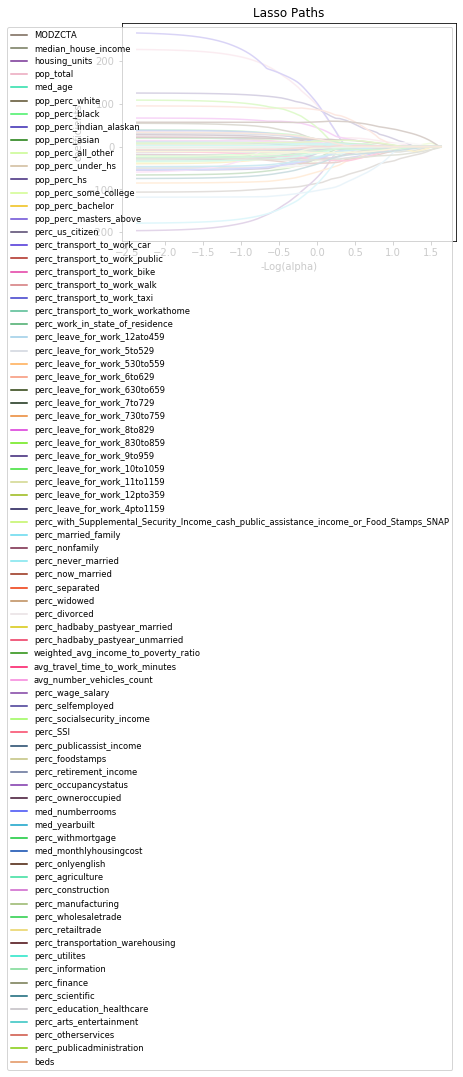

In [181]:
# Plot the regularization paths:
# Display results

# make legend small ==
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# make legend small ==

plt.figure(1)
colors = itertools.cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = np.log10(alphas_lasso)
i = 0
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=np.random.rand(3,), label=data_columns[i])
    i += 1

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Paths')
plt.axis('tight')
plt.legend(prop=fontP)
plt.show()

### step 2. gridsearch to find optimal alpha

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0, max_iter=1000)
alphas = np.logspace(-1.5, 3, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(train_data, train_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1493.209372340105, tolerance: 52.50999430561836
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2879.4439025220636, tolerance: 57.188803896455845
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2050.778502608362, tolerance: 46.71309164545459
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380.251387

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([3.16227766e-02, 4.52035366e-02, 6.46167079e-02, 9.23670857e-02,
       1.32035178e-01, 1....
       2.30180731e+00, 3.29034456e+00, 4.70342034e+00, 6.72335754e+00,
       9.61077966e+00, 1.37382380e+01, 1.96382800e+01, 2.80721620e+01,
       4.01280703e+01, 5.73615251e+01, 8.19960824e+01, 1.17210230e+02,
       1.67547492e+02, 2.39502662e+02, 3.42359796e+02, 4.89390092e+02,
       6.99564216e+02, 1.00000000e+03])}],
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=None, verbose=0)

In [183]:
print('best regularization param:', clf.best_params_['alpha'])
alpha = clf.best_params_['alpha']

best regularization param: 4.703420341698635


### step 3. train lasso

In [184]:
from sklearn.linear_model import ElasticNet
lasso_model = ElasticNet(alpha=alpha, l1_ratio=1)
lasso_model.fit(train_data, train_y)

ElasticNet(alpha=4.703420341698635, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### step 4. pull out nonzero columns

In [185]:
for col, val in zip(data_columns, lasso_model.coef_.tolist()):
    if val != 0:
        print(col, end=",\n")

pop_perc_indian_alaskan,
pop_perc_asian,
pop_perc_hs,
pop_perc_some_college,
pop_perc_bachelor,
perc_transport_to_work_car,
perc_transport_to_work_public,
perc_transport_to_work_bike,
perc_transport_to_work_workathome,
perc_leave_for_work_6to629,
perc_leave_for_work_7to729,
perc_leave_for_work_730to759,
perc_leave_for_work_10to1059,
perc_leave_for_work_12pto359,
perc_divorced,
weighted_avg_income_to_poverty_ratio,
perc_socialsecurity_income,
perc_SSI,
med_monthlyhousingcost,


In [186]:
lasso_model.coef_

array([-0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.35875553, -3.00235866,  0.        ,
        0.        ,  7.15578223,  2.6054261 , -4.60908726, -0.        ,
       -0.        ,  0.79256394, -4.18312286, -4.28275704, -0.        ,
       -0.        , -8.91881684,  0.        ,  0.        ,  0.        ,
        0.        , 12.57205158,  0.        ,  6.68072292, -0.99903487,
       -0.        , -0.        , -0.        , -0.77207648, -0.        ,
       11.91300991,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  5.32855753,
       -0.        , -0.        , -0.4395194 ,  0.        ,  0.        ,
       -0.        , -0.        ,  2.11948939,  2.14521906, -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -5.53413926, -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.  

In [187]:
lasso_model.score(test_data, test_y)

-0.5345065281671539